# Exploratory Data Analysis of kaggle data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('../datasets/kaggle_data_cleaned.csv')

In [3]:
df.head()

,Gender,Age,Sleep Duration,Working Professional or Student,Profession,Study Degree,Work/Study Hours,Financial Stress,Dietary Habits,Suicidal Thoughts,Family Mental Illness History,Depression,Academic/Work Pressure,Study/Job Satisfaction
0,Female,49.0,More than 8 hours,Working Professional,Chef,BHM,1.0,2.0,Healthy,No,No,0,5.0,2.0
1,Male,26.0,Less than 5 hours,Working Professional,Teacher,LLB,7.0,3.0,Unhealthy,Yes,No,1,4.0,3.0
2,Male,33.0,5-6 hours,Student,Student,B.Pharm,3.0,1.0,Healthy,Yes,No,1,5.0,2.0
3,Male,22.0,Less than 5 hours,Working Professional,Teacher,BBA,10.0,1.0,Moderate,Yes,Yes,1,5.0,1.0
4,Female,30.0,5-6 hours,Working Professional,Business Analyst,BBA,9.0,4.0,Unhealthy,Yes,Yes,0,1.0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140624 entries, 0 to 140623
Data columns (total 14 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Gender                           140624 non-null  object 
 1   Age                              140624 non-null  float64
 2   Sleep Duration                   140624 non-null  object 
 3   Working Professional or Student  140624 non-null  object 
 4   Profession                       140624 non-null  object 
 5   Study Degree                     140624 non-null  object 
 6   Work/Study Hours                 140624 non-null  float64
 7   Financial Stress                 140624 non-null  float64
 8   Dietary Habits                   140624 non-null  object 
 9   Suicidal Thoughts                140624 non-null  object 
 10  Family Mental Illness History    140624 non-null  object 
 11  Depression                       140624 non-null  int64  
 12  Ac

In [5]:
# Convert object columns to category 
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).astype('category')

## Correlation

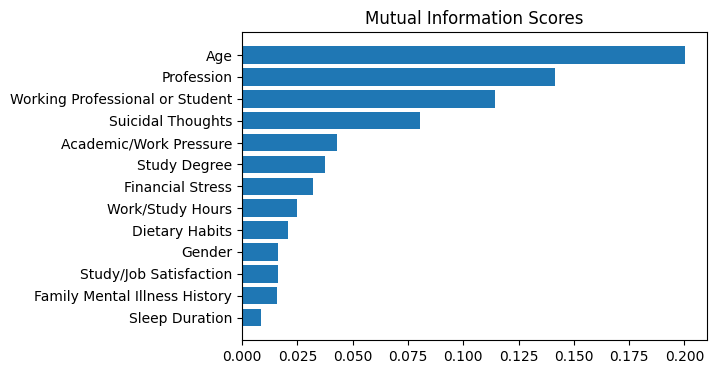

In [6]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

X = df.copy()
y = X.pop("Depression")

# Label encoding for categoricals
for colname in X.select_dtypes("category"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(6, 4))
plot_mi_scores(mi_scores)

### Key Observations from the Chart
Most Informative Features:

Age: The highest MI score, indicating that age is the most important feature in determining the target variable (depression). This suggests a strong relationship between a person's age and depression levels.

Profession: The second most informative feature. This might reflect differences in depression levels based on job type, job stress, or job satisfaction.
Working Professional or Student: Also has a significant MI score, suggesting that being a student or professional strongly influences depression levels, possibly due to workload or academic stress.
Moderately Informative Features:

Suicidal Thoughts: This psychological indicator is an important predictor of depression, as expected.

Academic/Work Pressure: Indicates that academic or workplace stress contributes significantly to depression.

Financial Stress: Highlights that economic pressure has a moderate relationship with depression.
Less Informative Features:

Study Degree: Has some importance, indicating that the level of education may influence depression levels.

Work/Study Hours and Study/Job Satisfaction: These features are less significant but still relevant, showing that workload and satisfaction impact mental health.

Dietary Habits: A low MI score, suggesting minimal direct impact on depression compared to other factors.
Least Informative Features:

Sleep Duration, Family Mental Illness History, and Gender: These features have very low MI scores, meaning they provide little information about the target variable in this dataset. While these might be theoretically relevant, they may not be significant in this specific dataset.

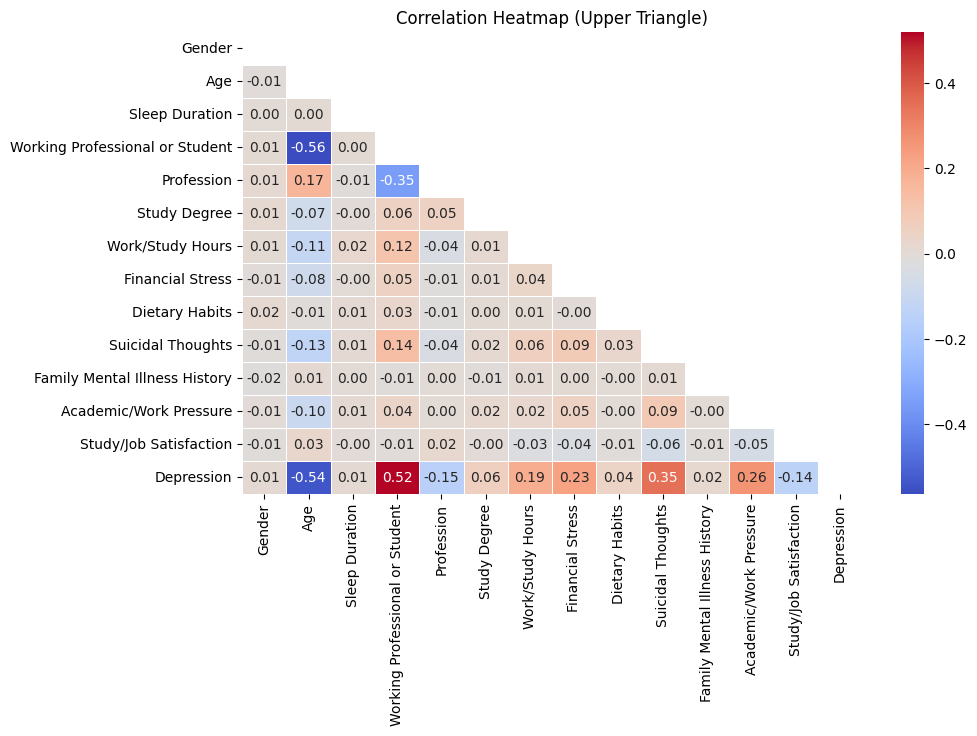

In [7]:
check = X.copy()
check['Depression'] = y
corr_matrix = check.corr(method='spearman')

# Mask the lower triangle (set it to NaN)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap (Upper Triangle)")
plt.show()

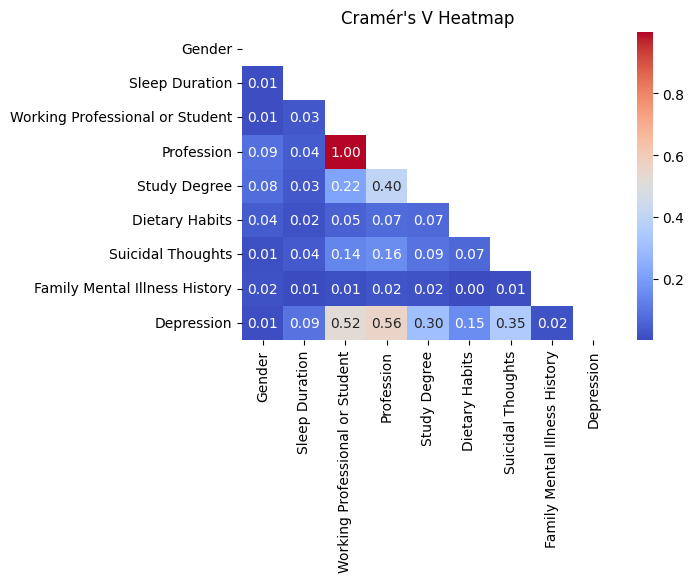

In [8]:
import scipy.stats as ss

# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = ss.chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))
category_cols = ['Gender','Sleep Duration','Working Professional or Student','Profession','Study Degree','Dietary Habits','Suicidal Thoughts','Family Mental Illness History','Depression']
# Create a matrix for Cramér's V between categorical columns
cramers_v_matrix = pd.DataFrame(index=category_cols, columns=category_cols)

for col1 in category_cols:
    for col2 in category_cols:
        cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Display Cramér's V matrix
cramers_v_matrix = cramers_v_matrix.astype(float)

# Plot the heatmap
mask = np.triu(np.ones_like(cramers_v_matrix, dtype=bool))
plt.figure(figsize=(6, 4))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True,mask=mask)
plt.title("Cramér's V Heatmap")
plt.show()

## Data Visualization¶

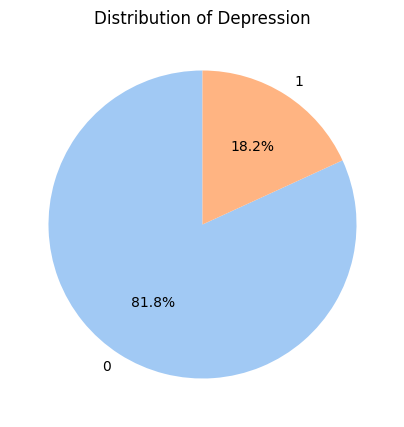

In [9]:
depression_counts = df['Depression'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(depression_counts, labels=depression_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel', len(depression_counts)), startangle=90)
    
plt.title('Distribution of Depression')
plt.show()

The 81.8%/18.2% class distribution is an important insight that suggests a significant class imbalance. This should be taken into consideration during preprocessing and model training to improve the model's ability to correctly predict the minority class. Techniques like resampling, changing evaluation metrics, and adjusting algorithm parameters can help make the model more effective at handling imbalanced data.

## 1. Categorical Features

In [10]:
df.select_dtypes(include=['category']).columns

Index(['Gender', 'Sleep Duration', 'Working Professional or Student',
       'Profession', 'Study Degree', 'Dietary Habits', 'Suicidal Thoughts',
       'Family Mental Illness History'],
      dtype='object')

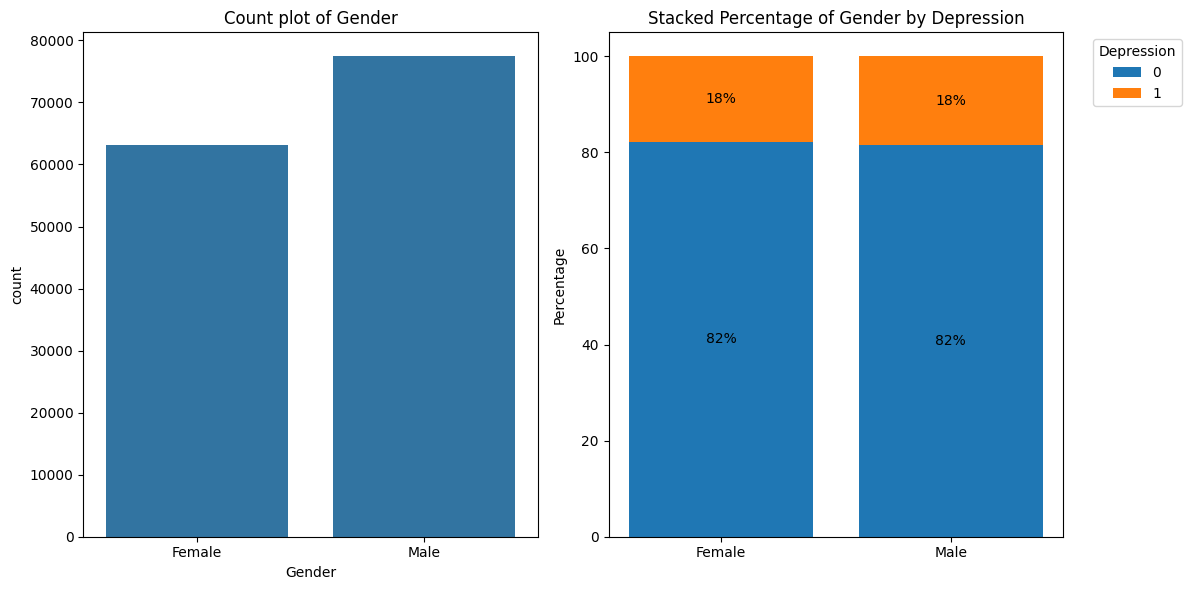

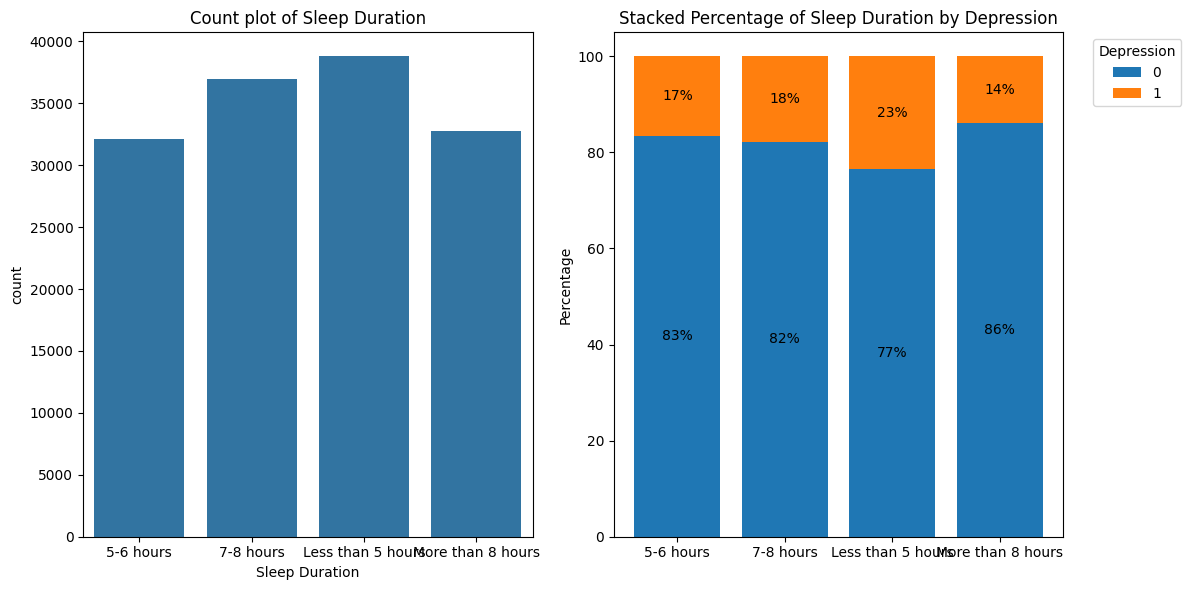

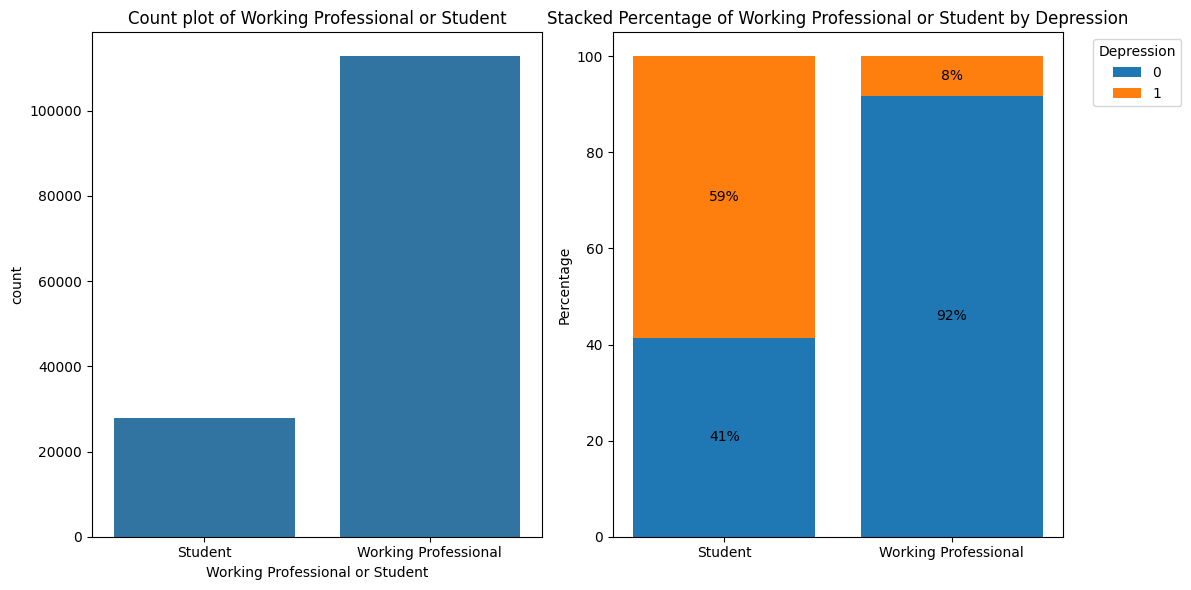

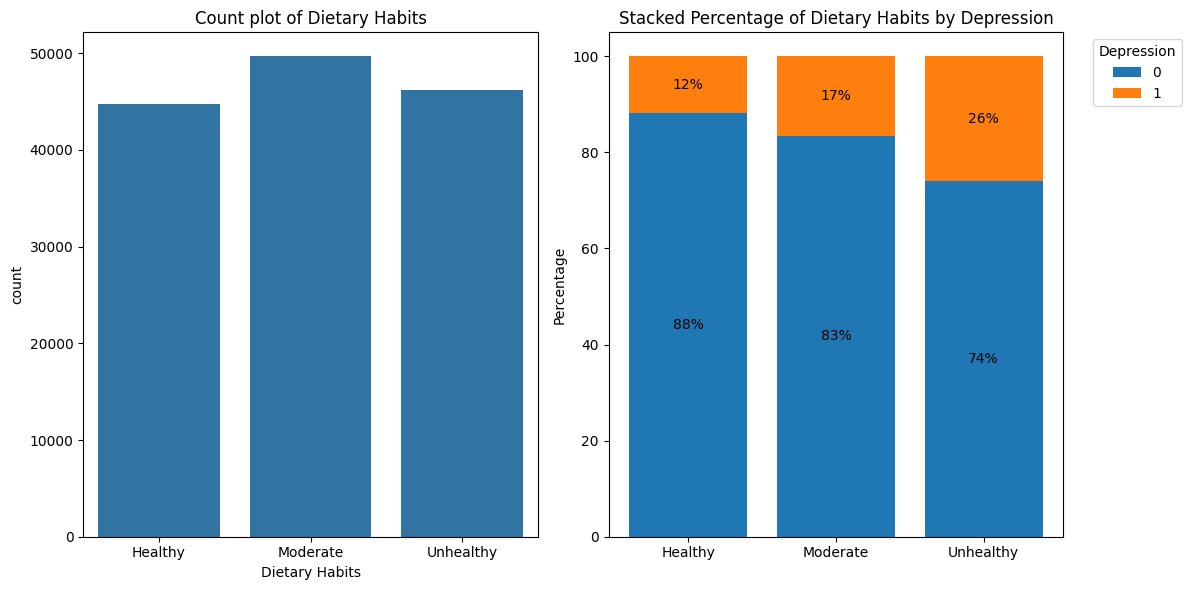

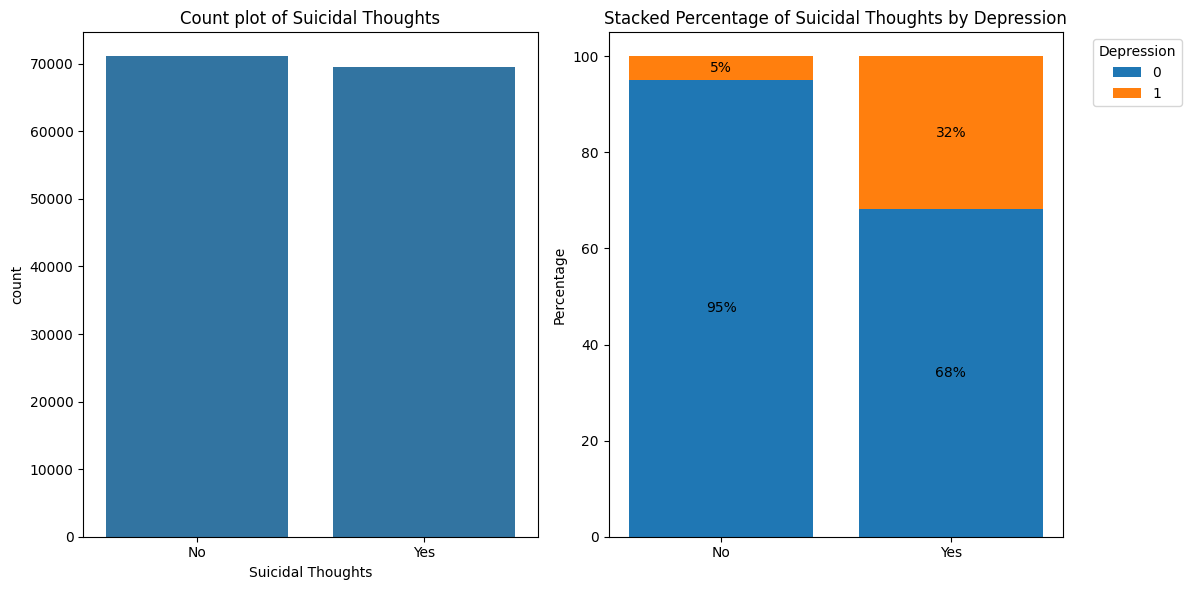

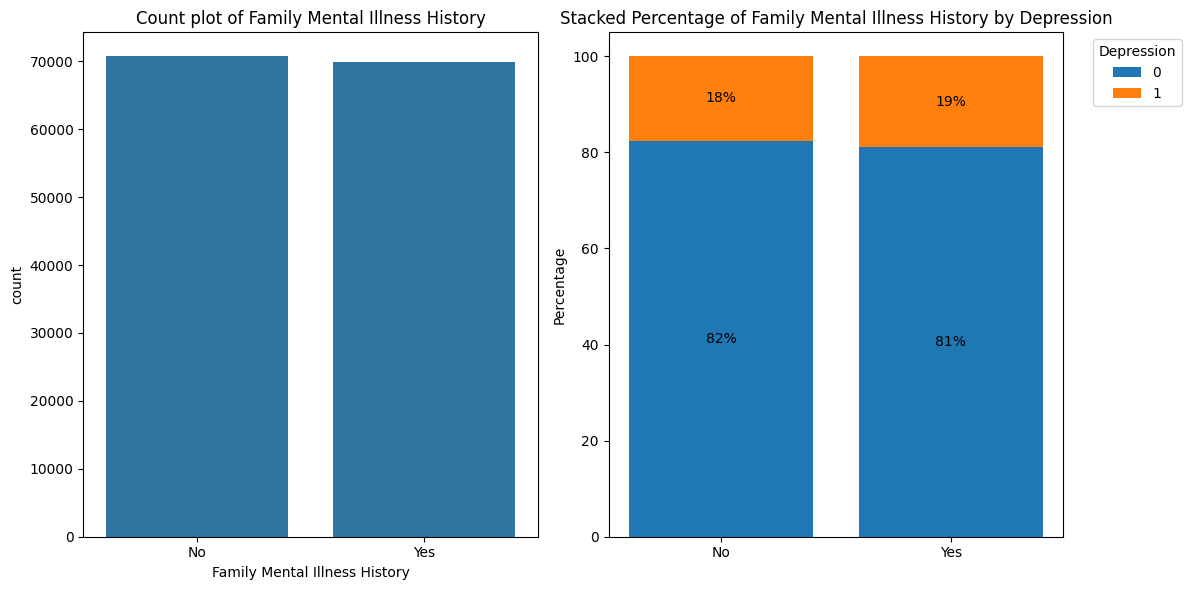

In [11]:
# Iterate over all columns in the DataFrame
for col in df.columns:
    # Check if the column's data type is 'category' and has <=10 unique values
    if df[col].dtype == 'category' and df[col].nunique() <= 10: 
        # Create a 1x2 subplot
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        
        # Count plot for the column
        sns.countplot(x=col, data=df, ax=ax[0])
        ax[0].set_title(f"Count plot of {col}")
        
        # Prepare data for the stacked percentage plot
        crosstab = pd.crosstab(df[col], df['Depression'], normalize='index') * 100  # Normalize by row to get percentages
        bottom = pd.Series(0, index=crosstab.index)  # Track the bottom position for stacking
        
        # Create the stacked percentage plot
        for category in crosstab.columns:
            ax[1].bar(crosstab.index, crosstab[category], bottom=bottom, label=f"{category}")
            # Annotate the percentage values
            for idx, value in enumerate(crosstab[category]):
                if value > 0:  # Only annotate non-zero values
                    ax[1].text(idx, bottom.iloc[idx] + value / 2, f"{value:.0f}%", ha='center', va='center')
            bottom += crosstab[category]  # Update the bottom position
        
        ax[1].set_title(f"Stacked Percentage of {col} by Depression")
        ax[1].set_ylabel("Percentage")
        ax[1].legend(title='Depression',bbox_to_anchor=(1.05, 1), loc='upper left')
        ax[1].set_xticks(range(len(crosstab.index)))
        ax[1].set_xticklabels(crosstab.index)

        # Adjust layout for better spacing
        plt.tight_layout()
        plt.show()

Features affect depression:

Working Professional or Student = 'Student' 

Sleep Duration = 'less than 5 hours'

Dietary Habits = 'Unhealthy'

Suicide thought = yes

### `Study Degree` Feature

In [12]:
df['Study Degree'].value_counts()

Study Degree
Class 12    14707
B.Ed        11688
B.Arch       8740
B.Com        8110
B.Pharm      5851
BCA          5736
M.Ed         5666
MCA          5228
BBA          5029
BSc          5023
MSc          4876
LLM          4646
M.Pharm      4536
M.Tech       4475
B.Tech       4423
LLB          4346
BHM          4304
MBA          3816
BA           3749
ME           3630
MD           3382
MHM          3286
PhD          3103
BE           3103
M.Com        3091
MBBS         3080
MA           2886
Unknown       114
Name: count, dtype: int64

In [13]:
# map the Study Degree feature
def type_degree(df):
    def map_degree(degree):
        if degree.startswith('B'):
            return 'Bachelor’s Degree'
        elif degree.startswith('P'):
            return 'PhD'
        elif degree.startswith('C'):
            return 'High School'
        elif degree.startswith('L') and degree.endswith('B'):
            return 'Bachelor’s Degree'
        elif degree.startswith('L') and degree.endswith('M'):
            return 'Master’s Degree'
        elif degree.startswith('M'):
            return 'Master’s Degree'
        else:
            return 'Unknown'  

    df['Study Degree'] = df['Study Degree'].apply(map_degree)
    return df

type_degree(df)
df.head()

,Gender,Age,Sleep Duration,Working Professional or Student,Profession,Study Degree,Work/Study Hours,Financial Stress,Dietary Habits,Suicidal Thoughts,Family Mental Illness History,Depression,Academic/Work Pressure,Study/Job Satisfaction
0,Female,49.0,More than 8 hours,Working Professional,Chef,Bachelor’s Degree,1.0,2.0,Healthy,No,No,0,5.0,2.0
1,Male,26.0,Less than 5 hours,Working Professional,Teacher,Bachelor’s Degree,7.0,3.0,Unhealthy,Yes,No,1,4.0,3.0
2,Male,33.0,5-6 hours,Student,Student,Bachelor’s Degree,3.0,1.0,Healthy,Yes,No,1,5.0,2.0
3,Male,22.0,Less than 5 hours,Working Professional,Teacher,Bachelor’s Degree,10.0,1.0,Moderate,Yes,Yes,1,5.0,1.0
4,Female,30.0,5-6 hours,Working Professional,Business Analyst,Bachelor’s Degree,9.0,4.0,Unhealthy,Yes,Yes,0,1.0,1.0


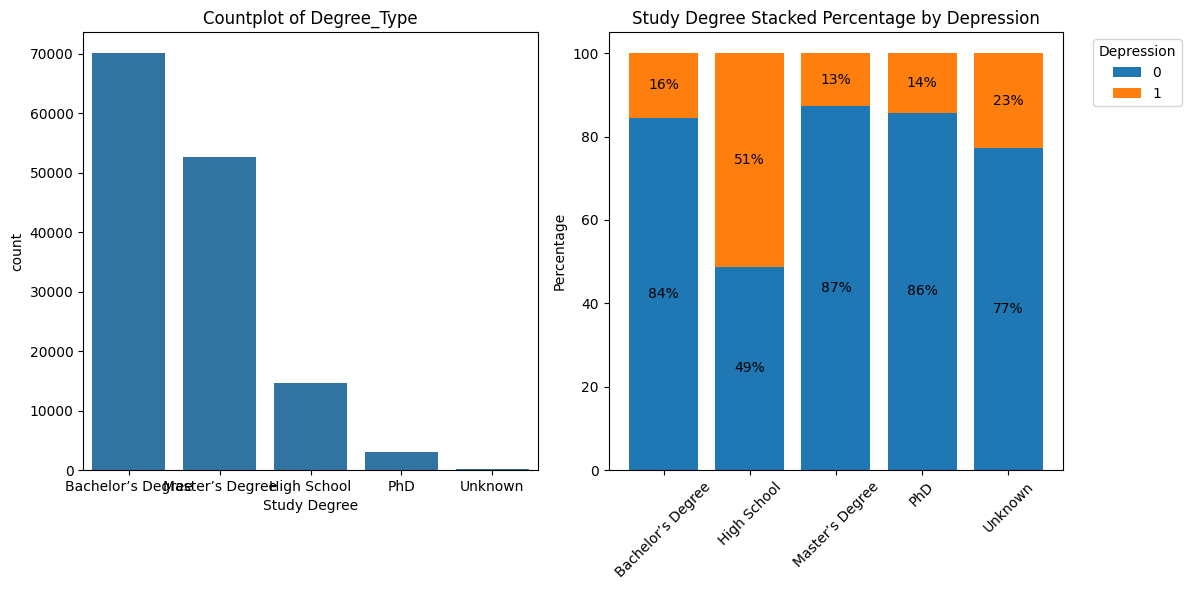

In [14]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Countplot for Degree_Type
sns.countplot(data=df, x='Study Degree', ax=axes[0])
axes[0].set_title('Countplot of Degree_Type')

# Plot 2: Stacked percentage bar plot for Degree_Type with hue='Depression'
# Prepare data for the stacked percentage plot
crosstab = pd.crosstab(df['Study Degree'], df['Depression'], normalize='index') * 100  # Normalize by row to get percentages
bottom = pd.Series(0, index=crosstab.index)  # Track the bottom position for stacking

# Create the stacked percentage plot
for category in crosstab.columns:
    axes[1].bar(crosstab.index, crosstab[category], bottom=bottom, label=f"{category}")
    # Annotate the percentage values
    for idx, value in enumerate(crosstab[category]):
        if value > 0:  # Only annotate non-zero values
            axes[1].text(idx, bottom.iloc[idx] + value / 2, f"{value:.0f}%", ha='center', va='center')
    bottom += crosstab[category]  # Update the bottom position

# Add titles, labels, and legend
axes[1].set_title('Study Degree Stacked Percentage by Depression')
axes[1].set_ylabel('Percentage')
axes[1].set_xticks(range(len(crosstab.index)))
axes[1].set_xticklabels(crosstab.index, rotation=45)
axes[1].legend(title='Depression',bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for clarity
plt.tight_layout()
plt.show()

Key Finding: Individuals with "High School" degree show the highest depression rate.

## 2. Numerical Features

In [15]:
df.select_dtypes(include=['int64', 'float64']).columns

Index(['Age', 'Work/Study Hours', 'Financial Stress', 'Depression',
       'Academic/Work Pressure', 'Study/Job Satisfaction'],
      dtype='object')

### `Age` Feature 

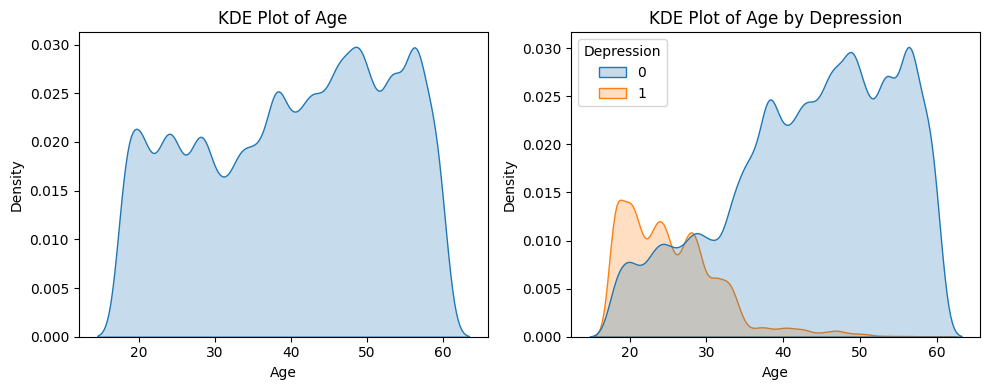

In [16]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot 1: KDE plot for Age
sns.kdeplot(data=df, x='Age', ax=axes[0],fill=True)
axes[0].set_title('KDE Plot of Age')

# Plot 2: KDE plot for Age with hue='Depression'
sns.kdeplot(data=df, x='Age', hue='Depression', ax=axes[1],fill=True)
axes[1].set_title('KDE Plot of Age by Depression')

# Adjust layout for clarity
plt.tight_layout()
plt.show()

<Axes: xlabel='Age', ylabel='Count'>

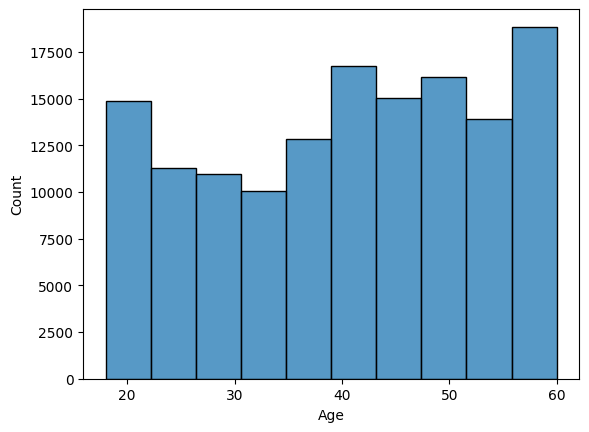

In [17]:
sns.histplot(x='Age',data=df,bins=10)

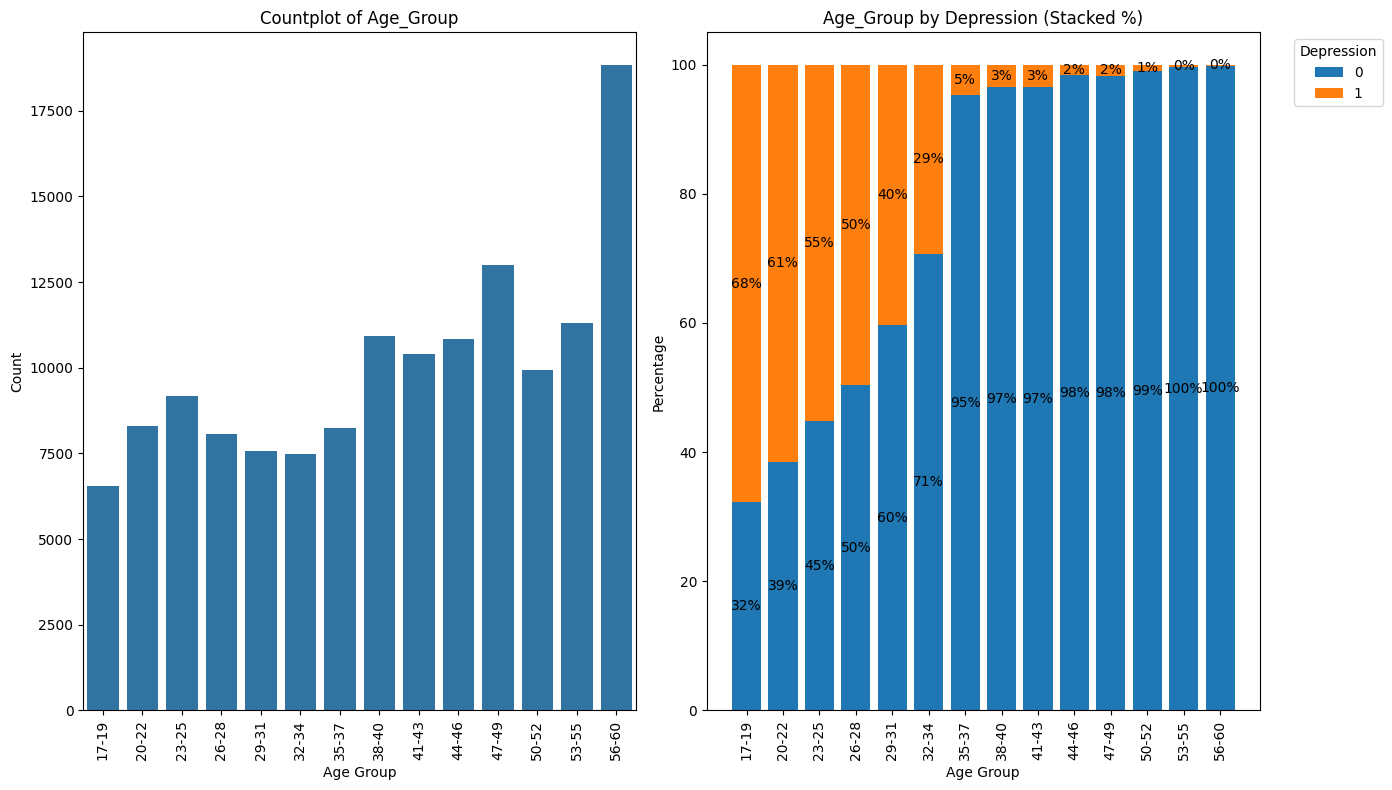

In [18]:
def age_group(df, age_column='Age'):
    # Manually define bins for the age ranges: 17-19, 20-22, ..., 57-60
    bins = [17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 61]
    labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]  

    # Create the 'Age_Group' column using pd.cut
    df['Age_Group'] = pd.cut(df[age_column], bins=bins, labels=labels, right=False, include_lowest=True)

    # Convert 'Age_Group' to an ordered categorical type
    df['Age_Group'] = pd.Categorical(df['Age_Group'], categories=labels, ordered=True)
    return df

df = age_group(df)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 8))

# Plot 1: Countplot for Age_Group
sns.countplot(data=df, x='Age_Group', ax=ax[0])
ax[0].set_title('Countplot of Age_Group')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_xlabel('Age Group')
ax[0].set_ylabel('Count')

# Prepare data for the stacked percentage plot
crosstab = pd.crosstab(df['Age_Group'], df['Depression'], normalize='index') * 100  # Normalize to percentages
bottom = pd.Series(0, index=crosstab.index)  # Initialize bottom tracker for stacking

# Plot 2: Stacked percentage bar plot
for category in crosstab.columns:
    ax[1].bar(crosstab.index, crosstab[category], bottom=bottom, label=f"{category}")
    # Add percentage annotations
    for idx, value in enumerate(crosstab[category]):
        if value > 0:  # Annotate only non-zero percentages
            ax[1].text(idx, bottom.iloc[idx] + value / 2, f"{value:.0f}%", ha='center', va='center')
    bottom += crosstab[category]  # Update the bottom for the next segment

# Set title, labels, and legend for the second plot
ax[1].set_title('Age_Group by Depression (Stacked %)')
ax[1].set_xlabel('Age Group')
ax[1].set_ylabel('Percentage')
ax[1].legend(title='Depression', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()


In [19]:
df['Age_Group'].unique()

['47-49', '26-28', '32-34', '20-22', '29-31', ..., '53-55', '50-52', '44-46', '35-37', '17-19']
Length: 14
Categories (14, object): ['17-19' < '20-22' < '23-25' < '26-28' ... '47-49' < '50-52' < '53-55' < '56-60']

Key Finding: Young individuals are the age group most likely to experience depression.

Depression Rate: Higher prevalence compared to other age groups.

### `Academic/Work Pressure` & `Study/Job Satisfaction` Features

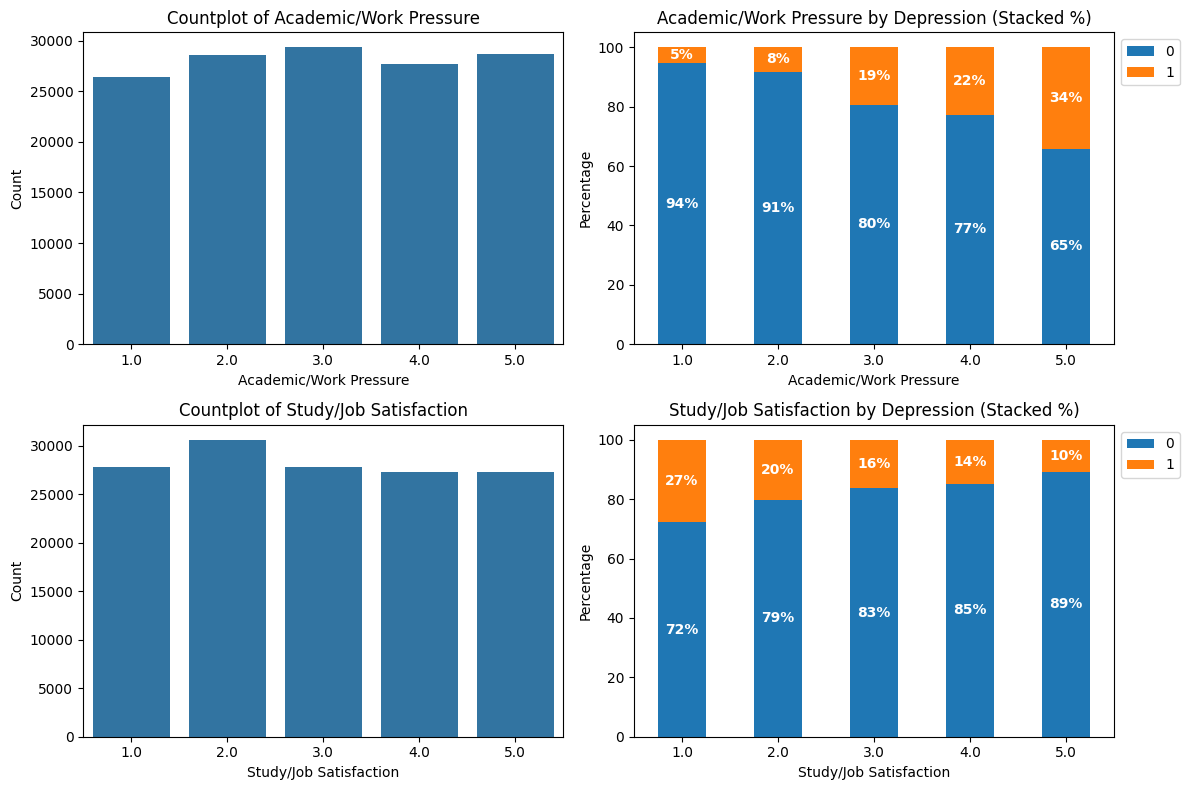

In [20]:
def plot_count_and_stacked(data, column, target, ax_count, ax_stacked):
    # Plot count plot
    sns.countplot(data=data, x=column, ax=ax_count)
    ax_count.set_title(f'Countplot of {column}')
    ax_count.set_xlabel(column)
    ax_count.set_ylabel('Count')
    # Create the stacked percentage bar plot
    percentage_data = data.groupby([column, target]).size().unstack(fill_value=0)
    percentage_data = percentage_data.div(percentage_data.sum(axis=1), axis=0) * 100
    percentage_data.plot(kind='bar', stacked=True, ax=ax_stacked)
    ax_stacked.set_title(f'{column} by {target} (Stacked %)')
    ax_stacked.set_xlabel(column)
    ax_stacked.set_ylabel('Percentage')
    # Annotate bars with percentages
    for p in ax_stacked.patches:
        height = p.get_height()
        if height > 0:  # Only annotate non-zero heights
            ax_stacked.annotate(f'{int(height)}%', (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() / 2.),ha='center', va='center',fontsize=10, color='white', fontweight='bold')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# Plot for Academic/Work Pressure
plot_count_and_stacked(df, 'Academic/Work Pressure', 'Depression', axes[0, 0], axes[0, 1])
# Plot for Study/Job Satisfaction
plot_count_and_stacked(df, 'Study/Job Satisfaction', 'Depression', axes[1, 0], axes[1, 1])
# Adjust layout and legends
for ax in axes.flat:
    ax.set_xticks(ax.get_xticks())  # Ensure proper tick positions
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
for ax in axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


Key Insight:

Satisfaction: Positively correlates with depression (higher satisfaction = lower depression).

Pressure: Negatively correlates with depression (higher pressure = higher depression).

### Work/Study Hours - Financial Stress

In [21]:
df.select_dtypes(include=['int64', 'float64']).columns

Index(['Age', 'Work/Study Hours', 'Financial Stress', 'Depression',
       'Academic/Work Pressure', 'Study/Job Satisfaction'],
      dtype='object')

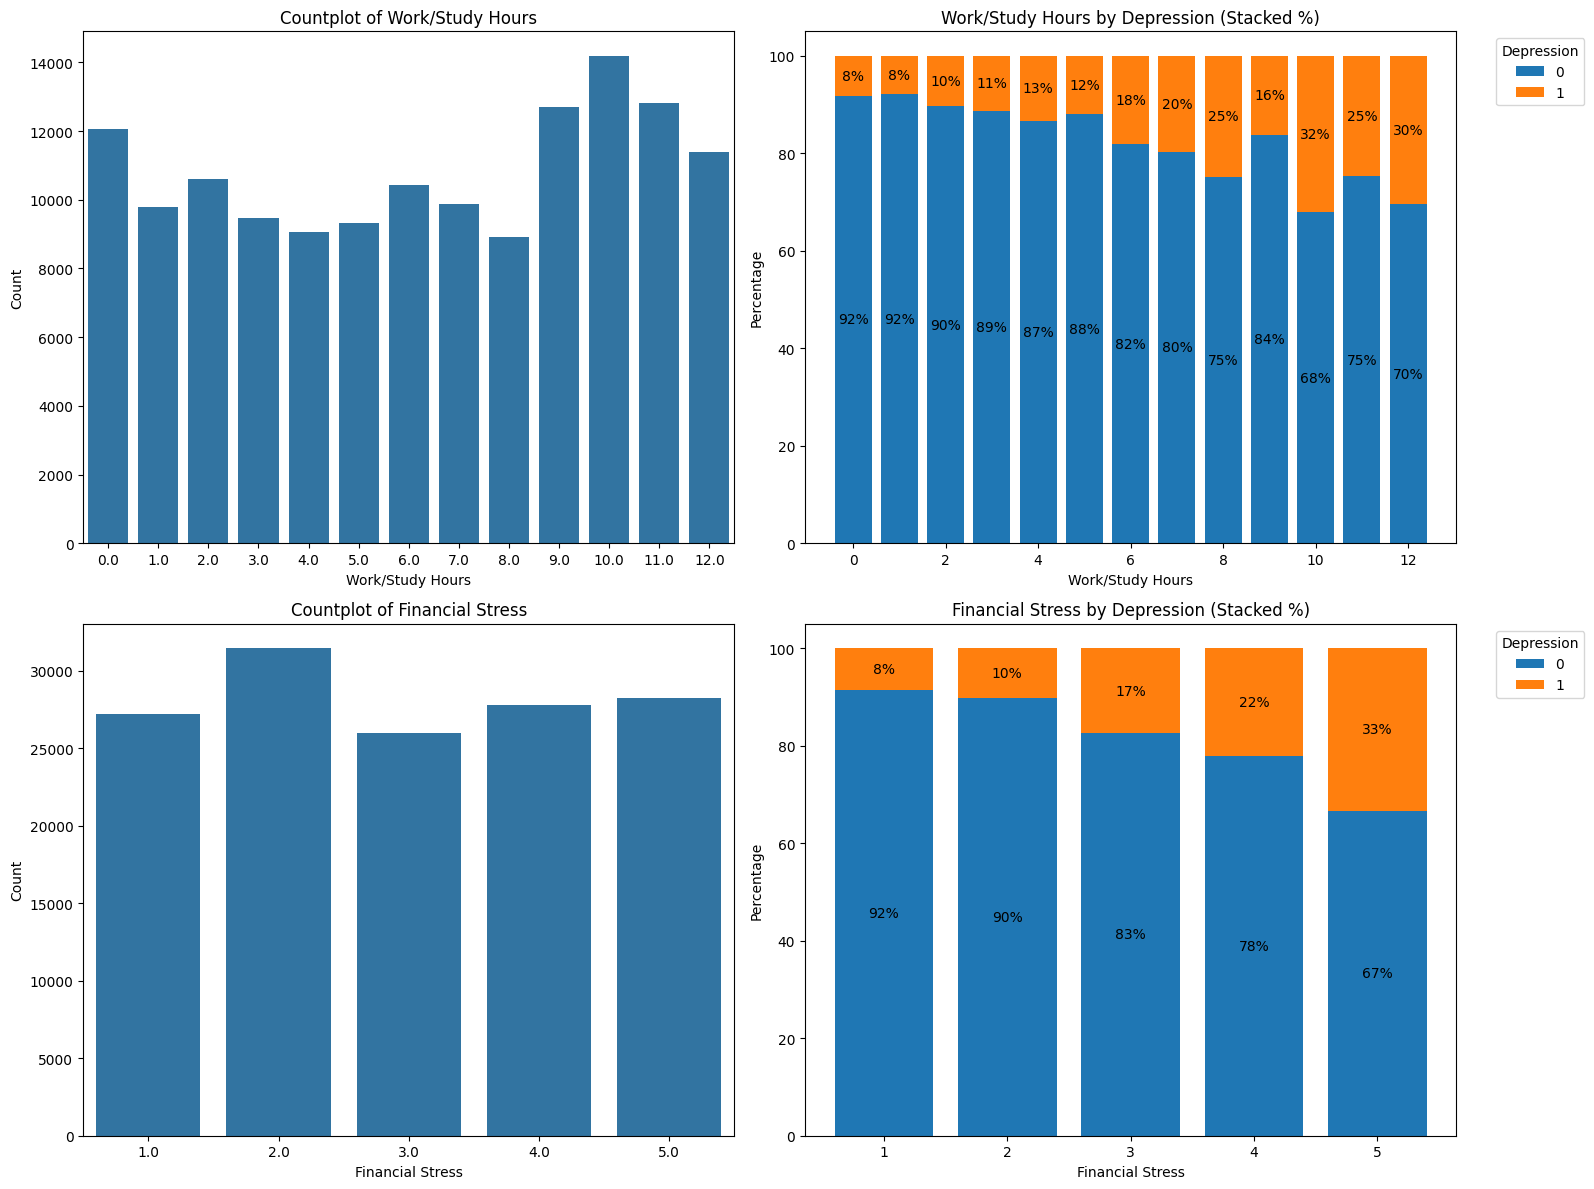

In [22]:
def plot_count_and_stacked_percentage(data, column, target, ax_count, ax_stacked):
    # Plot 1: Countplot
    sns.countplot(data=data, x=column, ax=ax_count)
    ax_count.set_title(f'Countplot of {column}')
    ax_count.set_xlabel(column)
    ax_count.set_ylabel('Count')

    # Plot 2: Stacked percentage bar plot
    crosstab = pd.crosstab(data[column], data[target], normalize='index') * 100
    bottom = pd.Series(0, index=crosstab.index)
    for category in crosstab.columns:
        ax_stacked.bar(crosstab.index, crosstab[category], bottom=bottom, label=f"{category}")
        for label in crosstab.index:
            value = crosstab.at[label, category]
            if value > 0:
                ax_stacked.text(label, bottom[label] + value / 2, f"{value:.0f}%", ha='center', va='center')
        bottom += crosstab[category]

    ax_stacked.set_title(f'{column} by {target} (Stacked %)')
    ax_stacked.set_xlabel(column)
    ax_stacked.set_ylabel('Percentage')
    ax_stacked.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left')

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Plot for 'Work/Study Hours'
plot_count_and_stacked_percentage(df, 'Work/Study Hours', 'Depression', ax[0, 0], ax[0, 1])

# Plot for 'Financial Stress'
plot_count_and_stacked_percentage(df, 'Financial Stress', 'Depression', ax[1, 0], ax[1, 1])

# Adjust layout
plt.tight_layout()
plt.show()


Key Insight:

Work/Study Hours; Financial Stress: Negatively correlates with depression

more Work/Study hours = higher depression.

higher Financial Stress = higher depression.

In [23]:
df.head()

,Gender,Age,Sleep Duration,Working Professional or Student,Profession,Study Degree,Work/Study Hours,Financial Stress,Dietary Habits,Suicidal Thoughts,Family Mental Illness History,Depression,Academic/Work Pressure,Study/Job Satisfaction,Age_Group
0,Female,49.0,More than 8 hours,Working Professional,Chef,Bachelor’s Degree,1.0,2.0,Healthy,No,No,0,5.0,2.0,47-49
1,Male,26.0,Less than 5 hours,Working Professional,Teacher,Bachelor’s Degree,7.0,3.0,Unhealthy,Yes,No,1,4.0,3.0,26-28
2,Male,33.0,5-6 hours,Student,Student,Bachelor’s Degree,3.0,1.0,Healthy,Yes,No,1,5.0,2.0,32-34
3,Male,22.0,Less than 5 hours,Working Professional,Teacher,Bachelor’s Degree,10.0,1.0,Moderate,Yes,Yes,1,5.0,1.0,20-22
4,Female,30.0,5-6 hours,Working Professional,Business Analyst,Bachelor’s Degree,9.0,4.0,Unhealthy,Yes,Yes,0,1.0,1.0,29-31


In [24]:
df.to_csv('../datasets/kaggle_data_after_EDA.csv', index=False)
